# Multivariate RNN Regression in TensorFlow 2

Author: **Ivan Bongiorni**, Data Scientist. [LinkedIn profile](https://www.linkedin.com/in/ivan-bongiorni-b8a583164/).

This time, I will show a multivariate RNN regression. The model will produce forecasts based not just on the dependent variable's history, but also on external variables that are assumed to be influential.

The dataset employed is the **UCI Air Quality Dataset**. Our goal is to explain pollution levels (pm 2.5) using the following set of variables:

y:
   - **pm2.5**: PM2.5 concentration
   
X:
   - **DEWP**: Dew Point
   - **TEMP**: Temperature
   - **PRES**: Pressure
   - **Iws**: Cumulated wind speed
   - **Is**: Cumulated hours of snow
   - **Ir**: Cumulated hours of rain

Data are collected hourly.

The model was trained using **Google Colab's GPUs** to save time.

In [1]:
import time

import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

# This command works on Google Colab only
# automatically imports latest TF version
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

from matplotlib import pyplot as plt

# Read file from Colab Notebook
from google.colab import drive
drive.mount('/content/drive')

TensorFlow 2.x selected.
2.1.0-rc1
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This dataset version is taken from Jason Brownlee's [repository](https://github.com/jbrownlee/Datasets/blob/master/pollution.csv), used in his [blogbost](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/) on LSTM regressions.

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv')

In [3]:
# Add y lagged
df['y_lag1'] = df['pm2.5'].shift(1)

# remove NaN's
df.dropna(axis = 0, inplace = True)

print(df.shape)

(41543, 14)


In [4]:
df.reset_index(drop = True, inplace = True)

df.drop(['No', 'year', 'month', 'day', 'hour', 'cbwd'], axis = 1, inplace = True)

df.head(10)

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,y_lag1
0,148.0,-15,-4.0,1020.0,2.68,0,0,129.0
1,159.0,-11,-5.0,1021.0,3.57,0,0,148.0
2,181.0,-7,-5.0,1022.0,5.36,1,0,159.0
3,138.0,-7,-5.0,1022.0,6.25,2,0,181.0
4,109.0,-7,-6.0,1022.0,7.14,3,0,138.0
5,105.0,-7,-6.0,1023.0,8.93,4,0,109.0
6,124.0,-7,-5.0,1024.0,10.72,0,0,105.0
7,120.0,-8,-6.0,1024.0,12.51,0,0,124.0
8,132.0,-7,-5.0,1025.0,14.30,0,0,120.0
9,140.0,-7,-5.0,1026.0,17.43,1,0,132.0


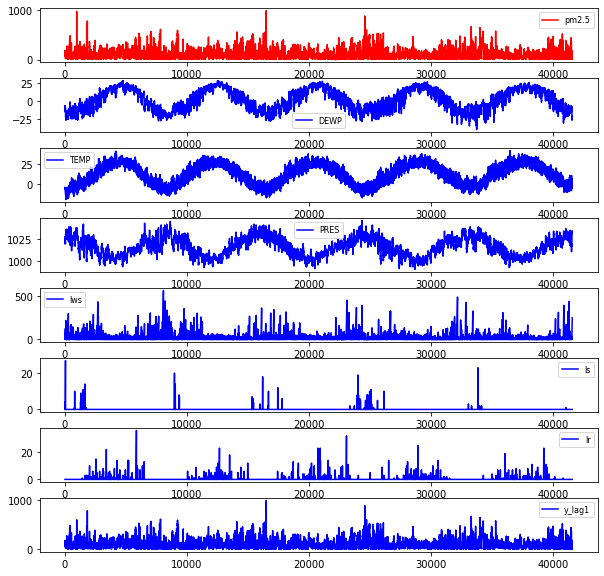

In [5]:
# Let's take a look at my dataframe

fig, ax = plt.subplots(df.shape[1], 1, figsize=(10, 10))
plt.subplots_adjust(hspace=0.3)

for i in range(df.shape[1]):
    color = 'r' if i == 0 else 'b'
    ax[i].plot(df[ df.columns[i] ], color, label = df.columns[i])
    ax[i].legend(prop={'size': 8})
plt.show()

In [0]:
# Take X and y numpy arrays out of df

X = df.drop('pm2.5', axis = 1)
X = X.values

y = df['pm2.5'].values

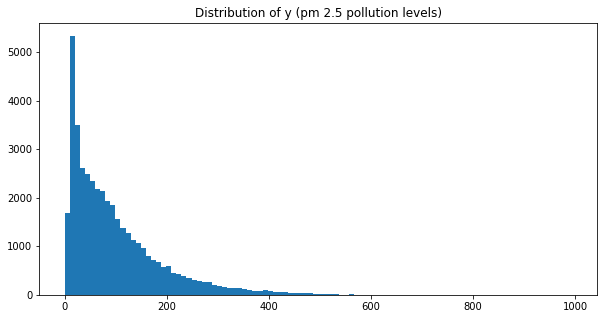

In [7]:
plt.figure(figsize = (10, 5))
plt.hist(y, bins = 100)
plt.title('Distribution of y (pm 2.5 pollution levels)')
plt.show()

In [8]:
# Split Train and Test data temporally
test_size = 0.3
cutoff = int(X.shape[0] * (1 - test_size))

X_train, y_train = X[ :cutoff , : ], y[ :cutoff ]
X_test, y_test = X[ cutoff: , : ], y[ cutoff: ]

del X, y

print('X_train: {} , y_train: {}'.format(X_train.shape, y_train.shape))
print('X_test: {} , y_test: {}'.format(X_test.shape, y_test.shape))

X_train: (29080, 7) , y_train: (29080,)
X_test: (12463, 7) , y_test: (12463,)


In [0]:
# Scale separately X and Y:
from sklearn.preprocessing import MinMaxScaler

x_scaler = MinMaxScaler()
X_train = x_scaler.fit_transform(X_train)
X_test = x_scaler.transform(X_test)

y_min, y_max = np.min(y_train), np.max(y_train)
y_train = (y_train - y_min) / (y_max - y_min)
y_test = (y_test - y_min) / (y_max - y_min)

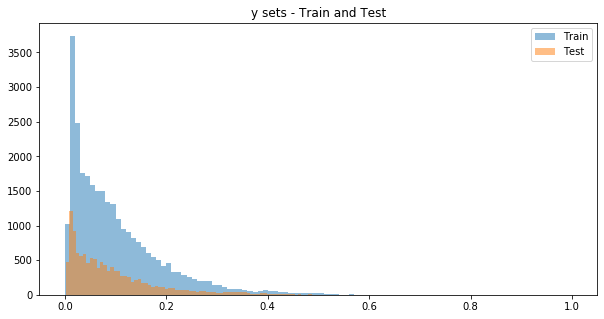

In [10]:
plt.figure(figsize = (10, 5))
plt.hist(y_train, bins = 100, label = 'Train', alpha = 0.5)
plt.hist(y_test, bins = 100, label = 'Test', alpha = 0.5)
plt.legend()
plt.title('y sets - Train and Test')
plt.show()

# RNN dataprep

The following preprocessing function is similar the ones employed in my previous RNN Notebooks.

It generates numpy matrices so that data can follow this pattern:

    ( Number of observations , Window size , Number of input variables )



In [0]:
def univariate_processing(variable, window):
    ''' RNN preprocessing for single variables.
    Can be iterated for multidimensional datasets. '''
    import numpy as np
    
    # create empty 2D matrix from variable
    V = np.empty((len(variable)-window+1, window))
    
    # take each row/time window
    for i in range(V.shape[0]):
        V[i,:] = variable[i : i+window]
    
    V = V.astype(np.float32) # set common data type
    
    return V


def RNN_regprep(df, y, len_input, len_pred): #, test_size):
    '''
    RNN preprocessing for multivariate regression. Builds multidimensional 
    dataset by iterating univariate preprocessing steps.
    Requires univariate_processing() function.
    Args:  df, y:                X and y data in numpy.array() format
           len_input, len_pred:  length of input and prediction sequences
    Returns:  X, Y matrices
    '''
    import numpy as np
    
    # create 3D matrix for multivariate input
    X = np.empty((df.shape[0]-len_input+1, len_input, df.shape[1]))
    
    # Iterate univariate preprocessing on all variables - store them in XM
    for i in range(df.shape[1]):
        X[ : , : , i ] = univariate_processing(df[:,i], len_input)
    
    # create 2D matrix of y sequences
    y = y.reshape((-1,))  # reshape to 1D if needed
    Y = univariate_processing(y, len_pred)
    
    ## Trim dataframes as explained
    X = X[ :-(len_pred + 1) , : , : ]
    Y = Y[len_input:-1 , :]
    
    # Set common datatype
    X = X.astype(np.float32)
    Y = Y.astype(np.float32)
    
    return X, Y

In [12]:
# Process all Train and Test data matrices
len_input = 5
no_vars = X_train.shape[1]

X_train, y_train = RNN_regprep(X_train, y_train, len_input, len_pred = 1)
X_test, y_test = RNN_regprep(X_test, y_test, len_input, len_pred = 1)

print('X_train: {} , y_train: {}'.format(X_train.shape, y_train.shape))
print('X_test: {} , y_test: {}'.format(X_test.shape, y_test.shape))

X_train: (29074, 5, 7) , y_train: (29074, 1)
X_test: (12457, 5, 7) , y_test: (12457, 1)


# RNN Architecture

Given the simple structure of the following dataset, I will keep my model as simple as possible. One Recurrent (LSTM) layer will process sequential informations, and the output node will perform the

Since pollution levels cannot, by definition, take negative values, I will ReLU the output node in order to keep my predictions in the meaningful range.

In [13]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.activations import relu

RNN = Sequential([ 
    
    LSTM(50, input_shape = (len_input, no_vars)), 
    
    Dense(1, activation = relu)
    
])

RNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                11600     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 11,651
Trainable params: 11,651
Non-trainable params: 0
_________________________________________________________________


## Training

As usual, I will use the **tf.function** decorator, to convert my training function into TensorFlow op, making it much faster than normal eager code.

In [14]:
###  TRAINING

# Choose no. cycles, epochs, batch size
n_epochs = 7
batch_size = 70
iterations = X_train.shape[0] // batch_size

# MAE works better than MSE in the [0, 1] range
loss = tf.keras.losses.MeanAbsoluteError()

optimizer = tf.optimizers.Adam(learning_rate = 0.0005)

loss_history = []


@tf.function
def train_model_on_batch():
    start = epoch * batch_size
    X_batch = X_train[start:start+batch_size, :, :]
    y_batch = y_train[start:start+batch_size, :]

    with tf.GradientTape() as tape:
        current_loss = loss(RNN(X_batch), y_batch)
    gradients = tape.gradient(current_loss, RNN.trainable_variables)
    optimizer.apply_gradients(zip(gradients, RNN.trainable_variables))
    return current_loss


for epoch in range(n_epochs+1):
    X_train, y_train = shuffle(X_train, y_train)
    
    for iteration in range(iterations):
        current_loss = train_model_on_batch()
    
    if epoch % 1 == 0:
        loss_history.append(current_loss.numpy())
        print("{}.   \t\tLoss: {}".format(
            epoch, loss_history[-1]))
#
print('\nTraining complete.')

0.   		Loss: 0.016661792993545532
1.   		Loss: 0.012308613397181034
2.   		Loss: 0.01134137250483036
3.   		Loss: 0.010995887219905853
4.   		Loss: 0.010786389000713825
5.   		Loss: 0.01136224064975977
6.   		Loss: 0.010211973451077938
7.   		Loss: 0.010331220924854279

Training complete.


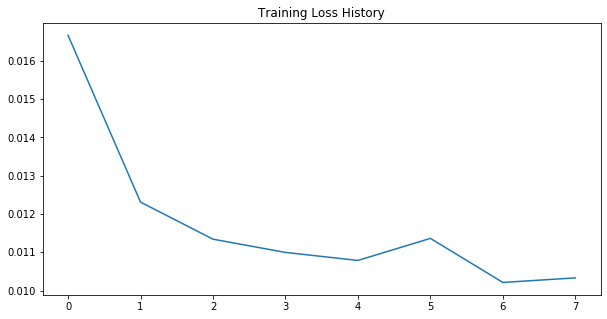

In [15]:
plt.figure(figsize = (10, 5))
plt.plot(loss_history)
plt.title('Training Loss History')
plt.show()

### Evaluate predictions

In [0]:
# Generate prediction on test data
P_test = RNN.predict(X_test)

# Revert scaling of y and prediction
y_test = y_test * (y_max - y_min) + y_min
P_test = P_test * (y_max - y_min) + y_min

# Reshape to 2D for visualization
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1]))
P_test = P_test.reshape((P_test.shape[0], P_test.shape[1]))

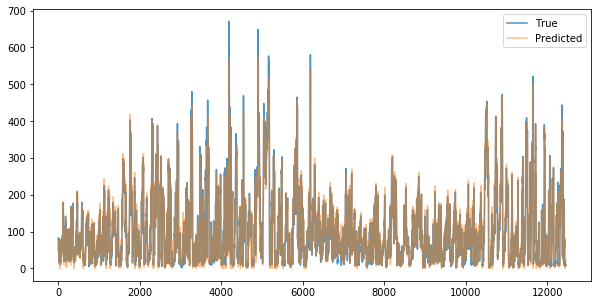

In [17]:
plt.figure(figsize = (10, 5))
plt.plot(y_test, label = 'True', alpha = 0.8)
plt.plot(P_test, label = 'Predicted', alpha = 0.5)
plt.legend()
plt.show()

In [18]:
# RMSE
print(np.sqrt(mean_squared_error(y_test, P_test)))

33.825844
